<a href="https://colab.research.google.com/github/jorgealarconlucas/TFG/blob/master/TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Trabajo Fin de Grado </center> 
## <center> Análisis de la evolución de los Parámetros del Hemograma utilizando Random Forest en Pacientes Infectados con SARS-CoV-2  </center> 
#### <center> *Jorge Alarcón Lucas* </center>

El objetivo de estudio se centra en estudiar de manera evolutiva qué variables obtenidas por medio de hemogramas y qué variables relacionadas con la coagulación son especialmente importantes para el diagnóstico preventivo de infección SARS-CoV2. Para ello el target será el estado de "FALLECE" y "UCI" del paciente. 

In [1]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

# 1. Visualización de datos 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Antes de entrenar un modelo predictivo, o antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar un análisis descriptivo de los mismos. De esta forma, entender mejor la información que contiene cada variable y detectar posibles errores.

In [3]:
db = pd.read_csv('/content/Base datos COVID-Linfos Actualizazda.xlsx - Valores seleccionados.csv')
#db = pd.read_excel('Base datos COVID-Linfos Actualizazda.xlsx') #no quites esta línea, coméntala cuando estés trabajando en tus datos

#Cambio las comas por puntos y de esa manera las columnas ya me salen float64, pero no se cambian las comas de las ultimas 4 columnas
#Sin embargo, si quito lo de las comas y puntos y lo añado mas adelante de otra manera, se cambian todas las comas por los puntos pero siguen
# tipo object

db.head(8)

,Número,Repetición NHC,Código Externo,FALLECE,UCI,Día del Año,19nCv,Día de POSITIVO,Días respecto a Positivo,Fecha,Edad del Paciente,Sexo del Paciente,GSRH,GRHPC,GRHRN,GRHCE,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,...,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ESSYS,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1
0,221.0,4,111561,NaN,NaN,90,NaN,NaN,NaN,30/03/20,85 años,M,NaN,O-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,319.0,13,102441,NaN,NaN,100,NaN,NaN,NaN,9/04/20,74 años,F,NaN,A-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,368.0,16,102441,NaN,NaN,104,NaN,NaN,NaN,13/04/20,74 años,F,NaN,A-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1759.0,9,104851,NaN,NaN,238,NaN,NaN,NaN,25/08/20,81 años,M,NaN,O+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,265277.0,7,11258,NaN,NaN,91,NaN,NaN,NaN,31/03/20,65 años,M,NaN,NaN,NaN,NaN,"5,57","2,55","45,8","2,27","40,8","0,47","8,4","0,23","4,1","0,04","0,7","0,01","0,2","5,31","15,7","46,3","87,2","29,6","33,9",13,0,0,NaN,NaN,...,896.0,430.0,"80,4","73,7","58,1",273.0,728.0,485.0,"120,9","122,2","63,9","50,2","154,8","2,55","45,8",291.0,557.0,521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"5,57",NaN,"5,77","5,57",NaN,NaN,0,0,"5,7","2,3","0,13","154,8","50,2",0,NaN
5,325932.0,11,115555,NaN,NaN,98,NaN,NaN,NaN,7/04/20,69 años,M,NaN,NaN,NaN,NaN,"7,03","3,84","54,7","2,26","32,1","0,76","10,8","0,11","1,6","0,05","0,7","0,01","0,1","5,73","15,3","47,8","83,4","26,7",32,"15,1",0,0,NaN,NaN,...,870.0,570.0,"80,7","70,1","57,9",273.0,786.0,650.0,"120,7",117,"64,6","47,8","147,1","3,84","54,7",313.0,565.0,654.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7,03",NaN,"7,08","7,03",NaN,NaN,0,0,"6,6","2,1","0,15","147,1","47,8",0,NaN
6,366742.0,5,111520,NaN,NaN,83,NaN,NaN,NaN,23/03/20,77 años,F,NaN,NaN,NaN,NaN,"7,04","3,69","52,5","2,41","34,2","0,69","9,8","0,21",3,"0,03","0,4","0,01","0,1","4,83",14,"44,3","91,7",29,"31,6","14,8",0,0,NaN,NaN,...,853.0,572.0,"76,8","72,7",56,269.0,790.0,631.0,115,"113,9",65,"49,9","152,6","3,69","52,5",314.0,581.0,582.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"7,04",NaN,"7,23","7,04",NaN,NaN,0,0,"5,4","1,8","0,13","152,6","49,9",0,NaN
7,374616.0,6,116651,NaN,NaN,97,NaN,NaN,NaN,6/04/20,70 años,F,NaN,NaN,NaN,NaN,"4,97","2,24",45,"2,18","43,9","0,47","9,5","0,05",1,"0,02","0,4","0,01","0,2","4,5","11,9",38,"84,4","26,4","31,3","15,5",0,0,NaN,NaN,...,934.0,623.0,81,"74,9","57,8",271.0,649.0,607.0,"121,6","120,3","67,5","52,7",150,"2,24",45,333.0,588.0,686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"4,97",NaN,"4,95","4,97",NaN,NaN,0,0,"11,5",5,"0,25",150,"52,7",0,NaN


In [4]:
db.head

<bound method NDFrame.head of        Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
0       221.0               4          111561  ...    NaN    NaN      NaN
1       319.0              13          102441  ...    NaN    NaN      NaN
2       368.0              16          102441  ...    NaN    NaN      NaN
3      1759.0               9          104851  ...    NaN    NaN      NaN
4    265277.0               7           11258  ...   50,2      0      NaN
..        ...             ...             ...  ...    ...    ...      ...
337  594293.0               5          128148  ...   47,6      0      NaN
338  594400.0               4          101609  ...   47,2      0      NaN
339  595190.0               6          138076  ...   54,7      0      NaN
340  597900.0               5          101609  ...   46,8      0      NaN
341  601867.0               7          101609  ...     47      0      NaN

[342 rows x 137 columns]>

In [5]:
Fallece = db.groupby(['FALLECE']).count() #0.0 son los NO fallecidos y 1.0 los fallecidos
print (Fallece)

         Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
FALLECE                                          ...                       
0.0          85              85              85  ...     53     53       45
1.0          11              11              11  ...      7      7        4

[2 rows x 136 columns]


In [6]:
UCI = db.groupby(['UCI']).count() #0.0 son los NO han entrado en UCI y 1.0 son los que han entrado en UCI
print (UCI)

     Número  Repetición NHC  Código Externo  ...  NEURI  ASLPL  19nCv.1
UCI                                          ...                       
0.0      85              85              85  ...     55     55       41
1.0      11              11              11  ...      5      5        8

[2 rows x 136 columns]


### 1.1 ELIMINACION DE COLUMNAS Y FILAS (CONSULTADO CON JAVIER)

Tras una visualización general y una charla con los sanitarios que han transferido la base de datos, se llega a la conclusión de que hay que hacer una limpieza de la misma. Hay columnas que su significado y valores no tienen ninguna relevancia para el estudio que se va a llevar a cabo.

- Elimino una columna que aparece aqui pero NO en la base de datos original, "Día de POSITIVO".

In [7]:
db1=db.drop(["Repetición NHC","Día de POSITIVO","Días respecto a Positivo","GSRH","GRHPC","GRHRN","GRHCE"],axis=1) #axis=1 ya que lo que elimino son columnas.


Teniendo en cuenta que la prueba PCR se hace como máximo una vez a la semana, si se cita a un mismo paciente dos veces en una misma semana, lo normal es que en esa segunda cita solo se haga una analítica. Sin embargo en ocasiones hay filas que no tienen información ni en 19nCv ni en los distintos parámetros del hemograma, por lo que esas filas deben ser eliminadas. (Código que viene a continuación)

A continuación elimino las filas que no aportan información.

In [8]:
db1= db1.dropna(thresh=9) #Mantiene solo las filas con al menos 9 valores que no sean NA. Esto me sirve ya que quiero eliminar aquellas filas
#que tengan NaN, es decir 19nCv y todos los parámetros del hemograma.
db1.shape

(320, 130)

Además teniendo en cuenta la informacion proporcionada por parte del hospital, elimino aquellas variables que son redundantes. Estas variables no aportan información adicional al futuro modelo de predicción.

In [9]:
db1=db1.drop(["NE_R","NEU_a","NEU_p","LY_R","LIN_a","LIN_p","MO_R","EO_R","BA_R"],axis=1) #axis=1 ya que lo que elimino son columnas.


### 1.2 AGRUPACION DE PACIENTES POR GRAVEDAD


- UCI=1 y FALLECE=1 --> Muy grave
- UCI=0 y FALLLECE=1 --> Muy grave

- UCI=1 y FALLECE=0 --> Grave
- UCI=0 y FALLECE=0 --> Sano

In [10]:
#counterFunc = db1.apply(
  #  lambda x: True if x(db1['UCI'] == 1.0) & (db1['FALLECE'] == 1.0) else False , axis=1)
#numOfRows = len(counterFunc[counterFunc == True].index)
#print('Row count is:',numOfRows)

In [11]:
data_all = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 1.0)]
data_death = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 1.0)]
data_regular = db1[(db1['UCI'] == 1.0) & (db1['FALLECE'] == 0.0)]
data_health = db1[(db1['UCI'] == 0.0) & (db1['FALLECE'] == 0.0)]

In [12]:
df_explicativo1 = pd.DataFrame({ #Creo un dataframe con el número de pacientes que cumple cada condición
  'Rows': [len(data_all.axes[0]), len(data_death.axes[0]), len(data_regular.axes[0]), len(data_health.axes[0])],
  }, index= ['1-1: MUY GRAVE', '0-1: MUY GRAVE', '1-0: REGULAR', '0-0: SANO'])

df_explicativo1

,Rows
1-1: MUY GRAVE,5
0-1: MUY GRAVE,6
1-0: REGULAR,6
0-0: SANO,79


Teniendo en cuenta cómo se reparte el número de pacientes en cada uno de los grupos, es decir se aprecia un desbalanceo, he decidido agrupar a los sano por una lado (sanos = 0) y por otro lado el resto de pacientes (grave = 1)


- UCI=1 y FALLECE=1 / UCI=0 y FALLLECE=1 / UCI=1 y FALLECE=0 --> NO SANO

- UCI=0 y FALLECE=0 --> SANO

In [13]:
df_explicativo2 = pd.DataFrame({ #Creo un dataframe con el número de pacientes que cumple cada condición
  'Rows': [len(data_all.axes[0]) + len(data_death.axes[0]) + len(data_regular.axes[0]), len(data_health.axes[0])],
  }, index= ['1:NO SANO', '0: SANO'])

df_explicativo2

,Rows
1:NO SANO,17
0: SANO,79


### 1.3 TIPO DE CADA COLUMNA

In [14]:
db1.info(verbose=True, null_counts=True) #Hay un total de 342 filas

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 4 to 341
Data columns (total 121 columns):
 #    Column             Non-Null Count  Dtype  
---   ------             --------------  -----  
 0    Número             319 non-null    float64
 1    Código Externo     320 non-null    int64  
 2    FALLECE            96 non-null     float64
 3    UCI                96 non-null     float64
 4    Día del Año        320 non-null    int64  
 5    19nCv              105 non-null    object 
 6    Fecha              320 non-null    object 
 7    Edad del Paciente  320 non-null    object 
 8    Sexo del Paciente  320 non-null    object 
 9    LEU                284 non-null    object 
 10   NEU                284 non-null    object 
 11   NEUp               284 non-null    object 
 12   LIN                284 non-null    object 
 13   LINp               284 non-null    object 
 14   MON                284 non-null    object 
 15   MONp               284 non-null    object 
 16   EOS   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


- Una vez se analizan las columnas, se puede observar que aquellas columnas con valores númericos separados por comas son de tipo **object**, por lo que las comas deben ser reemplazadas por puntos.

- Se observa como la variable **Edad** se encuentra como **object** debido a que la edad de cada paciente ha sido registrada seguida de la palabra **años**. Por ello, se crea una función que permita eliminar dicha palabra y a su vez convertir la variable a tipo numérico. 

- También, se precisa de otras variables como **object** cuando deberian de ser numéricas debido a la presencia de "----" que hacen referencia a valores perdidos. Por tanto, aquellas variables que presenten este conjunto de caracteres serán reemplazados por NaN. 

- Finalmente, tras los cambios realizados, se crea un código capaz de transformas las columnas tipo **object** en tipo **numérico**

In [15]:
# Eliminación de columnas del hemograma que no aportan información
db1=db1.drop(["FRSP","COMHE","AVSBL","AVSPL","AVSRJ","AVNRB","ESSYS"],axis=1) #axis=1 ya que lo que elimino son columnas.

In [16]:
#Cambio de comas por puntos
db1 = db1.replace(',','.', regex=True)

#Reemplazo esos caracteres por NaN
db1=db1.replace("----",np.nan)

# Función que elimina la palabra años
def only_digits (txt):
  return "".join(c for c in txt if c.isdigit())

db1["Edad del Paciente"] = db1["Edad del Paciente"].map(only_digits)

## MUY IMPORTANTE. Conversión de variables excepto 19nCv, Fecha, Sexo del Paciente y 19nCv.1 
# Una vez hecho el cambio de comas por puntos y haber introducido NaN por "----", este código me transforma los 'object' en 'numerics'
for i in db1:
  if not (i=="19nCv" or i=="Fecha" or i=="Sexo del Paciente" or i=="19nCv.1"):
    if db1[i].dtypes == object:
      db1[i] = pd.to_numeric(db1[i])

#Paso la variable "fecha" de tipo object a tipo datatime, para poder tratar con ella como una fecha.
db1["Fecha"]=pd.to_datetime(db1["Fecha"])

In [17]:
db1.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 4 to 341
Data columns (total 114 columns):
 #    Column             Non-Null Count  Dtype         
---   ------             --------------  -----         
 0    Número             319 non-null    float64       
 1    Código Externo     320 non-null    int64         
 2    FALLECE            96 non-null     float64       
 3    UCI                96 non-null     float64       
 4    Día del Año        320 non-null    int64         
 5    19nCv              105 non-null    object        
 6    Fecha              320 non-null    datetime64[ns]
 7    Edad del Paciente  320 non-null    int64         
 8    Sexo del Paciente  320 non-null    object        
 9    LEU                284 non-null    float64       
 10   NEU                284 non-null    float64       
 11   NEUp               284 non-null    float64       
 12   LIN                284 non-null    float64       
 13   LINp               284 non-null    float64      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [18]:
max_edad = db1['Edad del Paciente'].max() 
print("El paciente de mayor edad tiene:", max_edad,"años")

min_edad = db1['Edad del Paciente'].min() 
print("El paciente de menor edad tiene:", min_edad,"años")

El paciente de mayor edad tiene: 85 años
El paciente de menor edad tiene: 27 años


### 1.4 ¿CUANTOS PACIENTES HAY EN LA BASE DE DATOS? ¿CUANTAS REVISIONES TIENE CADA PACIENTE?

-El número de pacientes lo puedo sacar de la columna "Código externo". 

  1) Convierto esa columna en lista

  2) Saco valores únicos en esa lista de duplicados

Con esta función consigo convertir la columna "Código Externo" en lista, para que de esa manera sea más manejable

In [19]:
Codigo_lista = db1['Código Externo'].tolist()
#print("La lista de la columna Código Externo es:\n", Codigo_lista,"\n",type(Codigo_lista))

In [20]:
from collections import Counter

print(Counter(Codigo_lista).keys())
#print(Counter(Codigo_lista).values()) #Esta función me da el número de veces que sale repetido un paciente,
                  #es decir, el número de pruebas diferentes que se le hacen (igual que la siguiente función)

print("El número de pacientes en la base de datos es:", len(set(Codigo_lista))) 
#Me da el número de valores únicos en una lista de duplicados = número de pacientes

dict_keys([11258, 115555, 111520, 116651, 130481, 107747, 132015, 11372, 108894, 109115, 112823, 108897, 116806, 101480, 118401, 118023, 116005, 109036, 116159, 119737, 109887, 135217, 112135, 131267, 105140, 111786, 104798, 117212, 109339, 126455, 114183, 1214, 122958, 116033, 121289, 123676, 115847, 124738, 115784, 135062, 108527, 13299, 105639, 123456, 104849, 137304, 112511, 123156, 136922, 11197, 134855, 10074, 107746, 111561, 117398, 117462, 102441, 126638, 101660, 123724, 105582, 133617, 10092, 111310, 111339, 131394, 110435, 127383, 12016, 110607, 128124, 119766, 104851, 124850, 133978, 119606, 121358, 120418, 130937, 104431, 138076, 136647, 132432, 112894, 114495, 13397, 106066, 128864, 109129, 110011, 134492, 114819, 137069, 1164, 116453, 122654, 128148, 101609])
El número de pacientes en la base de datos es: 98


In [21]:
code = Counter(Codigo_lista) #diccionario con el recuento de citas por paciente
lista = pd.DataFrame.from_dict(code, orient='index').reset_index() #convierto la variable "code" en dataframe
lista = lista.rename(columns={'index':'Código externo', 0:'Número de citas'})
lista

,Código externo,Número de citas
0,11258,3
1,115555,4
2,111520,3
3,116651,3
4,130481,2
...,...,...
93,1164,3
94,116453,4
95,122654,2
96,128148,4


In [22]:
### NUMERO DE PACIENTES CON 1,2,3 y 4 citas
CITAS = lista.groupby(['Número de citas']).count() 
print (CITAS)

                 Código externo
Número de citas                
1                             3
2                            12
3                            39
4                            44


<Figure size 720x1440 with 0 Axes>

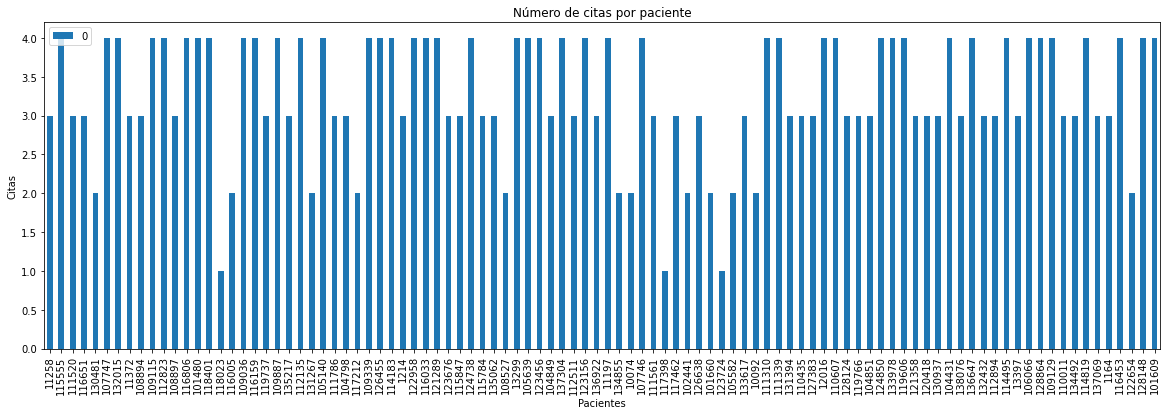

In [23]:
lista = pd.DataFrame.from_dict(code, orient='index')
plt.figure(figsize=(10,20))
lista.plot(kind='bar',figsize=(20,6), title='Número de citas por paciente', xlabel='Pacientes', ylabel='Citas') 
#es "bar" y no "hist" porque Counter está haciendo un recuento de frecuencia.

## 1.5 INTRODUCCION DE COLUMNAS "NUMERO DE LA REVISION" Y "LABEL" 


Una vez conozco el numero de citas de cada paciente, a continuación debo conseguir agrupar dichas citas y ordenarlas según "Fecha". Una vez conseguido, debo añadir una columna nueva indicando el número que corresponde a esa cita (1,2,3 o 4).

A continuación tengo que agrupar y ordenar las citas de cada uno de los pacientes. Posteriormente con ese agrupamiento podré crear 98 dataframes.

In [24]:
hola = db1.loc[db1["Código Externo"] == 137304]
hola = hola.sort_values('Fecha')
hola['Revision'] = range(1, 1+len(hola)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                        # en cuenta el número de citas de cada paciente.
hola

,Número,Código Externo,FALLECE,UCI,Día del Año,19nCv,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,...,IRF-Y,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1,Revision
236,496041.0,137304,NaN,NaN,93,Positivo,2020-02-04,50,F,6.93,4.08,58.9,2.13,30.7,0.56,8.1,0.07,1.0,0.06,0.9,0.03,0.4,4.42,12.3,38.1,86.2,27.8,32.3,13.6,0.0,0.0,NaN,NaN,NaN,NaN,189.0,189.0,NaN,NaN,11.2,...,NaN,525.0,894.0,630.0,80.0,80.6,58.7,283.0,774.0,652.0,120.3,118.9,69.0,49.0,152.6,321.0,633.0,740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.93,NaN,7.13,6.93,NaN,0.0,0.0,14.6,4.5,0.31,152.6,49.0,0.0,NaN,1
111,407283.0,137304,0.0,0.0,86,Positivo,2020-03-26,50,F,6.58,3.60,54.6,2.30,35.0,0.59,9.0,0.01,0.2,0.04,0.6,0.04,0.6,4.95,13.4,41.3,83.4,27.1,32.4,13.9,0.0,0.0,NaN,NaN,NaN,NaN,151.0,151.0,NaN,NaN,10.9,...,NaN,544.0,1046.0,637.0,84.6,81.3,62.8,221.0,732.0,657.0,126.6,118.9,68.5,51.9,156.1,308.0,616.0,713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.58,NaN,6.82,6.58,NaN,0.0,0.0,25.2,8.8,0.58,156.1,51.9,0.0,NaN,2
162,411851.0,137304,NaN,NaN,90,NaN,2020-03-30,50,F,7.42,3.91,52.7,2.70,36.4,0.58,7.8,0.12,1.6,0.05,0.7,0.06,0.8,4.77,12.8,39.4,82.6,26.8,32.5,13.5,0.0,0.0,NaN,NaN,NaN,NaN,233.0,233.0,NaN,NaN,11.4,...,NaN,649.0,910.0,607.0,78.6,79.1,57.7,281.0,672.0,661.0,121.0,120.6,65.1,50.3,150.2,326.0,577.0,708.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.42,NaN,7.46,7.42,NaN,0.0,0.0,14.4,5.3,0.39,150.2,50.3,0.0,NaN,3
237,496376.0,137304,NaN,NaN,99,NaN,2020-08-04,50,F,7.44,4.29,57.8,2.31,31.0,0.65,8.7,0.10,1.3,0.05,0.7,0.04,0.5,4.43,12.2,37.9,85.6,27.5,32.2,13.6,0.0,0.0,NaN,NaN,NaN,NaN,174.0,174.0,NaN,NaN,10.9,...,NaN,517.0,835.0,590.0,81.3,81.4,59.3,278.0,534.0,604.0,122.5,121.7,69.5,48.5,154.7,310.0,639.0,731.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.44,NaN,7.51,7.44,NaN,0.0,0.0,14.3,4.4,0.33,154.7,48.5,0.0,NaN,4


(Código utilizado para ir sacando los pacientes de la base de datos db1 e ir añadiendo una columna nueva "Revisión" con un valor, haciendo referencia dicho valor al orden de citas de cada paciente.)

In [25]:
#empty_df = pd.DataFrame()

#first = db1.loc[db1["Código Externo"] == 11258]
#first = first.sort_values('Fecha')
#first['Revision'] = range(1, 1+len(first)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                        # en cuenta el número de citas de cada paciente.

#empty_df = empty_df.append(first)

In [26]:
#lista_pacientes = Counter(Codigo_lista).keys()

#for i in lista_pacientes:
#    if i not in empty_df.values:
#     new = db1.loc[db1["Código Externo"] == i]
#     new = new.sort_values('Fecha')
#     new['Revision'] = range(1, 1+len(new)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

#     empty_df = empty_df.append(new)#cada vez que se itera se añade el df del paciente

#    else:
#      continue

#empty_df

Código en el que añado una nueva columna "Revisión" y hago dos dataframes uno con sanos y otro con no sanos. A cada uno de esos dataframes añado un nueva columna "label". Los sanos tiene label=0 y los enfermos label=1. Esto me ayudará en mi siguiente paso que es plotear cada variable.

Además con el código consigo que todas las revisiones del los pacientes sanos tengan una nueva columna donde ponga 0 y todas las revisiones de los pacientes no sanos tengan una columna donde ponga 1.

In [27]:
lista_pacientes = Counter(Codigo_lista).keys()

### INICIALIZO DATAFRAME DE SANOS
sanos_df = pd.DataFrame()

### INICIALIZO DATAFRAME DE NO SANOS
no_sanos_df = pd.DataFrame()

for i in lista_pacientes:  
      if i not in data_health.values:
        new_1 = db1.loc[db1["Código Externo"] == i]
        new_1 = new_1.sort_values('Fecha') #ordenar de la revision mas antigua a la mas reciente.
        new_1['Revision'] = range(1, 1+len(new_1)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_1 = new_1.assign(label=1) #Introduzco nueva columna con etiqueta 1 (NO SANO)

        no_sanos_df = no_sanos_df.append(new_1)

      else:
        new_2 = db1.loc[db1["Código Externo"] == i]
        new_2 = new_2.sort_values('Fecha')
        new_2['Revision'] = range(1, 1+len(new_2)) #en la nueva columna "Revision" se van a añadiendo valores de manera incremental desde 1 teniendo 
                                          # en cuenta el número de citas de cada paciente.

        new_2 = new_2.assign(label=0)#Introduzco nueva columna con etiqueta 0 (SANO)
      
        sanos_df = sanos_df.append(new_2)


In [28]:
no_sanos_df

,Número,Código Externo,FALLECE,UCI,Día del Año,19nCv,Fecha,Edad del Paciente,Sexo del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,...,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NE-WX,NE-WY,NE-WZ,RBCHE,RBC-Y,RTNC,RUPP,RET-Y,RPI,TNC-D,TNC-N,TNC-P,WBC-D,WBC-N,WBC-P,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,19nCv.1,Revision,label
44,400817.0,107747,NaN,NaN,76,NaN,2020-03-16,78,M,18.02,15.79,87.7,0.92,5.1,0.80,4.4,0.00,0.0,0.06,0.3,0.45,2.5,5.06,15.8,45.3,89.5,31.2,34.9,13.0,0.00,0.0,NaN,NaN,NaN,NaN,349.0,349.0,NaN,NaN,11.0,...,547.0,886.0,678.0,80.5,67.7,57.5,301.0,611.0,714.0,116.5,96.6,58.8,51.1,159.1,327.0,646.0,745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.02,NaN,17.88,18.02,NaN,0.4,0.08,15.2,0.8,0.14,159.1,51.1,8.7,NaN,1,1
87,405044.0,107747,NaN,NaN,80,NaN,2020-03-20,78,M,26.62,24.75,93.0,0.50,1.9,0.85,3.2,0.00,0.0,0.06,0.2,0.46,1.7,5.50,17.2,50.0,90.9,31.3,34.4,12.3,0.00,0.0,NaN,NaN,NaN,NaN,216.0,216.0,NaN,NaN,12.7,...,480.0,844.0,445.0,79.2,71.1,56.2,325.0,765.0,577.0,116.9,92.8,59.0,51.2,161.3,322.0,684.0,608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.62,NaN,27.10,26.62,NaN,0.3,0.08,20.0,0.4,0.10,161.3,51.2,16.0,NaN,2,1
9,394276.0,107747,1.0,0.0,70,Positivo,2020-10-03,78,M,10.84,8.92,82.3,1.10,10.1,0.59,5.4,0.05,0.5,0.05,0.5,0.13,1.2,5.40,16.9,49.3,91.3,31.3,34.3,12.8,0.00,0.0,NaN,NaN,NaN,NaN,192.0,192.0,NaN,NaN,11.1,...,405.0,744.0,665.0,83.9,79.3,58.7,246.0,664.0,692.0,125.8,131.0,63.6,55.9,155.2,322.0,662.0,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.84,NaN,10.74,10.84,NaN,1.2,0.13,19.1,1.9,0.21,155.2,55.9,11.8,NaN,3,1
13,396087.0,107747,NaN,NaN,72,NaN,2020-12-03,78,M,9.41,7.38,78.5,1.03,10.9,0.52,5.5,0.24,2.6,0.05,0.5,0.19,2.0,5.19,16.1,48.3,93.1,31.0,33.3,13.0,0.00,0.0,NaN,NaN,NaN,NaN,343.0,343.0,NaN,NaN,10.7,...,1048.0,987.0,570.0,78.3,73.0,57.8,291.0,786.0,539.0,120.2,109.4,61.2,55.0,153.8,338.0,600.0,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.41,NaN,9.47,9.41,NaN,1.2,0.11,24.3,2.7,0.25,153.8,55.0,10.7,NaN,4,1
34,399142.0,116159,0.0,1.0,77,Positivo,2020-03-17,68,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positivo,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,580085.0,114819,NaN,NaN,273,NaN,2020-09-29,69,F,13.67,8.29,60.7,2.08,15.2,2.54,18.6,0.02,0.1,0.08,0.6,0.66,4.8,5.12,14.5,42.3,82.6,28.3,34.3,13.4,0.01,0.1,NaN,NaN,NaN,NaN,207.0,207.0,NaN,NaN,12.4,...,541.0,818.0,689.0,79.5,72.1,58.1,228.0,531.0,631.0,118.6,114.9,63.4,35.4,131.2,419.0,762.0,906.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.68,NaN,13.25,13.67,NaN,1.4,0.19,13.9,2.1,0.29,131.2,35.4,9.1,NaN,4,1
328,584694.0,116453,NaN,NaN,275,NaN,2020-01-10,66,M,11.14,9.94,89.3,0.64,5.7,0.18,1.6,0.10,0.9,0.06,0.5,0.22,2.0,4.78,14.9,44.7,93.5,31.2,33.3,14.0,0.00,0.0,NaN,NaN,NaN,NaN,341.0,341.0,NaN,NaN,9.7,...,529.0,968.0,665.0,77.5,69.2,58.6,261.0,604.0,610.0,118.9,97.8,67.2,49.9,153.2,333.0,681.0,794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.14,NaN,10.99,11.14,NaN,0.5,0.06,17.2,1.0,0.11,153.2,49.9,9.4,NaN,1,1
332,588322.0,116453,NaN,NaN,279,NaN,2020-05-10,66,M,15.00,11.28,75.1,1.50,10.0,0.97,6.5,0.09,0.6,0.10,0.7,1.06,7.1,4.47,13.7,40.9,91.5,30.6,33.5,13.2,0.00,0.0,NaN,NaN,NaN,NaN,392.0,392.0,NaN,NaN,11.0,...,641.0,906.0,453.0,78.0,67.3,57.4,290.0,675.0,552.0,117.4,108.1,61.6,48.2,160.2,337.0,684.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00,NaN,15.10,15.00,NaN,0.3,0.04,7.3,0.7,0.11,160.2,48.2,2.7,NaN,2,1
336,593952.0,116453,NaN,NaN,283,NaN,2020-09-10,66,M,11.49,10.30

In [29]:
#### SI NO PONGO ESTO A LO HORA DE REPRESENTAR ME DA ERROR
#no_sanos_df.reset_index(drop=False, inplace = True)
#sanos_df.reset_index(drop=False, inplace = True)

## 1.6 REPRESENTACIÓN DE LOS DATOS (DataFrame)

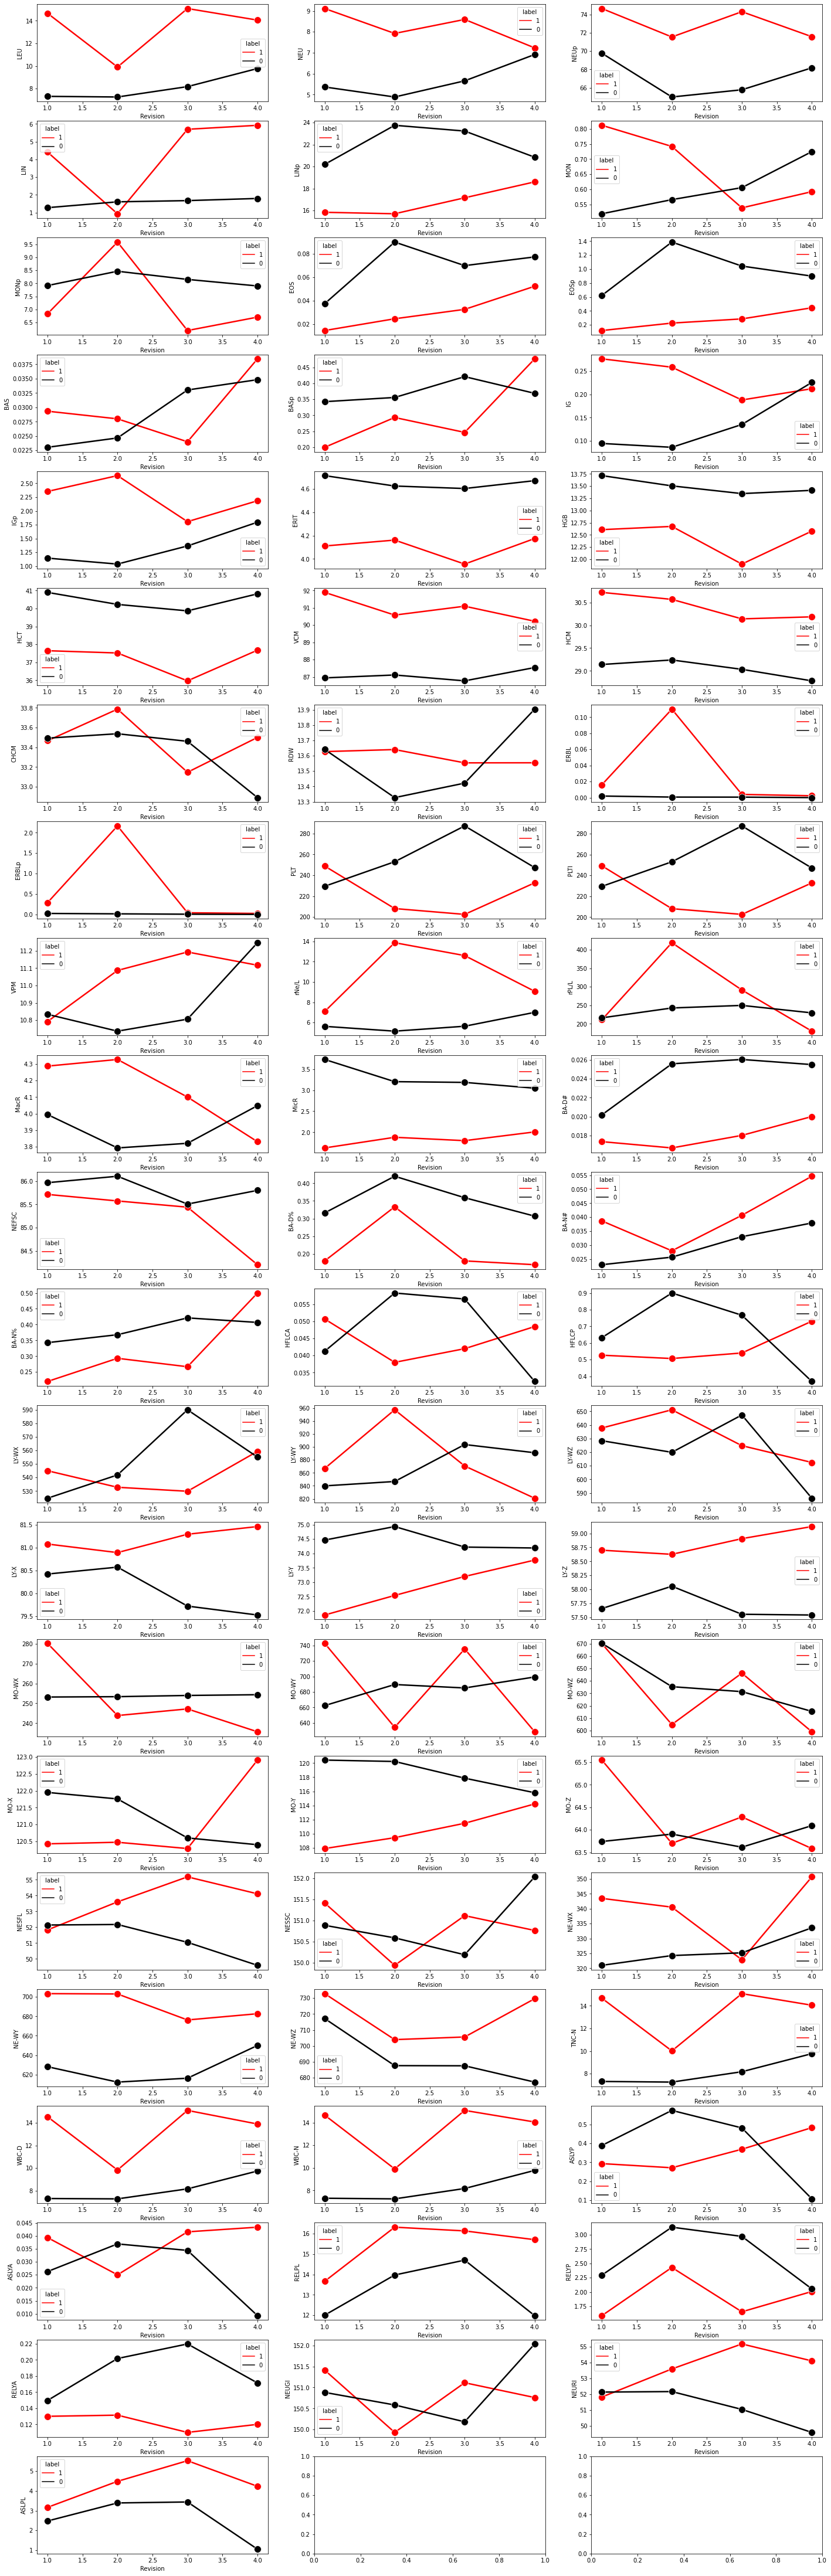

In [30]:
### LAS GRAFICAS NO EMPIEZAN EN CERO, PORQUE EN EL CODIGO EN EL QUE INTRODUZO LAS NUEVAS COLUMNAS HAGO QUE
# LA PRIMERA REVISION SEA "1".

#con el parámetro "ci" quito los intervalos de confianza

fig, axes = plt.subplots(22, 3, figsize=(24, 80)) #figsize = width x height

sns.lineplot(ax=axes[0, 0],data=no_sanos_df, x="Revision",y="LEU", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[0, 0],data=sanos_df, x="Revision", y="LEU", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[0, 1],data=no_sanos_df, x="Revision", y="NEU", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[0, 1],data=sanos_df, x="Revision", y="NEU", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[0, 2],data=no_sanos_df, x="Revision", y="NEUp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[0, 2],data=sanos_df, x="Revision", y="NEUp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[1, 0],data=no_sanos_df, x="Revision", y="LIN", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[1, 0],data=sanos_df, x="Revision", y="LIN", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[1, 1],data=no_sanos_df, x="Revision", y="LINp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[1, 1],data=sanos_df, x="Revision", y="LINp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[1, 2], data=no_sanos_df, x="Revision", y="MON", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[1, 2], data=sanos_df, x="Revision", y="MON", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[2, 0],data=no_sanos_df, x="Revision", y="MONp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[2, 0],data=sanos_df, x="Revision", y="MONp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[2, 1],data=no_sanos_df, x="Revision", y="EOS", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[2, 1],data=sanos_df, x="Revision", y="EOS", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[2, 2],data=no_sanos_df, x="Revision", y="EOSp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[2, 2],data=sanos_df, x="Revision", y="EOSp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[3, 0],data=no_sanos_df, x="Revision", y="BAS", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[3, 0],data=sanos_df, x="Revision", y="BAS", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[3, 1],data=no_sanos_df, x="Revision", y="BASp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[3, 1],data=sanos_df, x="Revision", y="BASp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[3, 2],data=no_sanos_df, x="Revision", y="IG", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[3, 2],data=sanos_df, x="Revision", y="IG", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[4, 0],data=no_sanos_df, x="Revision", y="IGp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[4, 0],data=sanos_df, x="Revision", y="IGp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[4, 1],data=no_sanos_df, x="Revision", y="ERIT", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[4, 1],data=sanos_df, x="Revision", y="ERIT", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[4, 2],data=no_sanos_df, x="Revision", y="HGB", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[4, 2],data=sanos_df, x="Revision", y="HGB", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[5, 0],data=no_sanos_df, x="Revision", y="HCT", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[5, 0],data=sanos_df, x="Revision", y="HCT", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[5, 1],data=no_sanos_df, x="Revision", y="VCM", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[5, 1],data=sanos_df, x="Revision", y="VCM", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[5, 2],data=no_sanos_df, x="Revision", y="HCM", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[5, 2],data=sanos_df, x="Revision", y="HCM", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[6, 0],data=no_sanos_df, x="Revision", y="CHCM", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[6, 0],data=sanos_df, x="Revision", y="CHCM", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[6, 1],data=no_sanos_df, x="Revision", y="RDW", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[6, 1],data=sanos_df, x="Revision", y="RDW", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[6, 2],data=no_sanos_df, x="Revision", y="ERBL", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[6, 2],data=sanos_df, x="Revision", y="ERBL", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[7, 0],data=no_sanos_df, x="Revision", y="ERBLp", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[7, 0],data=sanos_df, x="Revision", y="ERBLp", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[7, 1],data=no_sanos_df, x="Revision", y="PLT", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[7, 1],data=sanos_df, x="Revision", y="PLT", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[7, 2],data=no_sanos_df, x="Revision", y="PLTI", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[7, 2],data=sanos_df, x="Revision", y="PLTI", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[8, 0],data=no_sanos_df, x="Revision", y="VPM", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[8, 0],data=sanos_df, x="Revision", y="VPM", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[8, 1],data=no_sanos_df, x="Revision", y="rNe/L", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[8, 1],data=sanos_df, x="Revision", y="rNe/L", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[8, 2],data=no_sanos_df, x="Revision", y="rPL/L", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[8, 2],data=sanos_df, x="Revision", y="rPL/L", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[9, 0],data=no_sanos_df, x="Revision", y="MacR", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[9, 0],data=sanos_df, x="Revision", y="MacR", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[9, 1],data=no_sanos_df, x="Revision", y="MicR", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[9, 1],data=sanos_df, x="Revision", y="MicR", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[9, 2],data=no_sanos_df, x="Revision", y="BA-D#", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[9, 2],data=sanos_df, x="Revision", y="BA-D#", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[10, 0],data=no_sanos_df, x="Revision", y="NEFSC", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[10, 0],data=sanos_df, x="Revision", y="NEFSC", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[10, 1],data=no_sanos_df, x="Revision", y="BA-D%", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[10, 1],data=sanos_df, x="Revision", y="BA-D%", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[10, 2],data=no_sanos_df, x="Revision", y="BA-N#", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[10, 2],data=sanos_df, x="Revision", y="BA-N#", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[11, 0],data=no_sanos_df, x="Revision", y="BA-N%", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[11, 0],data=sanos_df, x="Revision", y="BA-N%", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[11, 1],data=no_sanos_df, x="Revision", y="HFLCA", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[11, 1],data=sanos_df, x="Revision", y="HFLCA", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[11, 2],data=no_sanos_df, x="Revision", y="HFLCP", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[11, 2],data=sanos_df, x="Revision", y="HFLCP", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[12, 0],data=no_sanos_df, x="Revision", y="LY-WX", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[12, 0],data=sanos_df, x="Revision", y="LY-WX", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[12, 1],data=no_sanos_df, x="Revision", y="LY-WY", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[12, 1],data=sanos_df, x="Revision", y="LY-WY", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[12, 2],data=no_sanos_df, x="Revision", y="LY-WZ", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[12, 2],data=sanos_df, x="Revision", y="LY-WZ", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[13, 0],data=no_sanos_df, x="Revision", y="LY-X", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[13, 0],data=sanos_df, x="Revision", y="LY-X", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[13, 1],data=no_sanos_df, x="Revision", y="LY-Y", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[13, 1],data=sanos_df, x="Revision", y="LY-Y", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[13, 2],data=no_sanos_df, x="Revision", y="LY-Z", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[13, 2],data=sanos_df, x="Revision", y="LY-Z", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[14, 0],data=no_sanos_df, x="Revision", y="MO-WX", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[14, 0],data=sanos_df, x="Revision", y="MO-WX", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[14, 1],data=no_sanos_df, x="Revision", y="MO-WY", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[14, 1],data=sanos_df, x="Revision", y="MO-WY", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[14, 2],data=no_sanos_df, x="Revision", y="MO-WZ", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[14, 2],data=sanos_df, x="Revision", y="MO-WZ", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[15, 0],data=no_sanos_df, x="Revision", y="MO-X", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[15, 0],data=sanos_df, x="Revision", y="MO-X", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[15, 1],data=no_sanos_df, x="Revision", y="MO-Y", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[15, 1],data=sanos_df, x="Revision", y="MO-Y", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[15, 2],data=no_sanos_df, x="Revision", y="MO-Z", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[15, 2],data=sanos_df, x="Revision", y="MO-Z", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[16, 0],data=no_sanos_df, x="Revision", y="NESFL", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[16, 0],data=sanos_df, x="Revision", y="NESFL", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[16, 1],data=no_sanos_df, x="Revision", y="NESSC", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[16, 1],data=sanos_df, x="Revision", y="NESSC", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[16, 2],data=no_sanos_df, x="Revision", y="NE-WX", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[16, 2],data=sanos_df, x="Revision", y="NE-WX", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[17, 0],data=no_sanos_df, x="Revision", y="NE-WY", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[17, 0],data=sanos_df, x="Revision", y="NE-WY", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[17, 1],data=no_sanos_df, x="Revision", y="NE-WZ", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[17, 1],data=sanos_df, x="Revision", y="NE-WZ", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[17, 2],data=no_sanos_df, x="Revision", y="TNC-N", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[17, 2],data=sanos_df, x="Revision", y="TNC-N", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[18, 0],data=no_sanos_df, x="Revision", y="WBC-D", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[18, 0],data=sanos_df, x="Revision", y="WBC-D", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[18, 1],data=no_sanos_df, x="Revision", y="WBC-N", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[18, 1],data=sanos_df, x="Revision", y="WBC-N", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[18, 2],data=no_sanos_df, x="Revision", y="ASLYP", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[18, 2],data=sanos_df, x="Revision", y="ASLYP", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[19, 0],data=no_sanos_df, x="Revision", y="ASLYA", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[19, 0],data=sanos_df, x="Revision", y="ASLYA", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[19, 1],data=no_sanos_df, x="Revision", y="RELPL", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[19, 1],data=sanos_df, x="Revision", y="RELPL", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[19, 2],data=no_sanos_df, x="Revision", y="RELYP", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[19, 2],data=sanos_df, x="Revision", y="RELYP", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[20, 0],data=no_sanos_df, x="Revision", y="RELYA", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[20, 0],data=sanos_df, x="Revision", y="RELYA", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[20, 1],data=no_sanos_df, x="Revision", y="NEUGI", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[20, 1],data=sanos_df, x="Revision", y="NEUGI", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[20, 2],data=no_sanos_df, x="Revision", y="NEURI", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[20, 2],data=sanos_df, x="Revision", y="NEURI", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

sns.lineplot(ax=axes[21, 0],data=no_sanos_df, x="Revision", y="ASLPL", hue="label", palette=['red'], linewidth=2.5, ci=None, marker="o", markersize= 12)
sns.lineplot(ax=axes[21, 0],data=sanos_df, x="Revision", y="ASLPL", hue="label", palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)

#plt.savefig("Gráficas_variables.png", bbox_inches='tight')

He graficado las 64 variables del hemograma con el que se está trabajando. En estas gráficas aparece en el eje X, los valores 1,2,3 y 4, que son las revisiones que puede tener cada uno de los pacientes, aunque no todos las tienen. Además, en la gráfica se pueden observar 2 curvas, una de ellas hace referencia a los NO SANOS --> 1 y la otra a los SANOS --> 0. 

Como ejemplo del significado de las gráficas diré que: cogiendo como ejemplo el valor que aparece en el punto 1 del eje X de la gráfica LEU; por una lado la curva roja con el número 1 es el valor medio de LEU de la primera revisión de todos los pacientes NO SANOS y por otro lado la curva negra con el valor 0 es el valor medio de LEU de la primera revisión de todos los pacientes SANOS.

# 2. Preprocesado de datos

### ¿Hasta que revisión se cuenta con un número adecuado de pacientes?

Se realiza el proyecto con un total de 4 revisiones. Se llega a esta conclusión de la siguiente forma; se dividen las variables de forma individual y se va representando cada uno de los valores de cada variable en cada revisión (teniendo así una visión de los valores de la variable para todos los pacientes en cada revisión a medida que pasa el tiempo). Esto se realiza con los pacientes sanos por un lado y los pacientes no sanos por el otro. Finalmente, se observa como con 4 revisiones se puede hacer un estudio amplio y completo de las variables. 

Además, de 98 pacientes, 44 pacientes presentan 4 revisiones, es decir el 44,89% de los pacientes presentes en la base de datos, porcentaje considerable que ayuda a tomar la decision de usar 4 revisiones.


In [31]:
db1 = pd.concat([sanos_df, no_sanos_df])
db1.shape

print(db1.columns)

Index(['Número', 'Código Externo', 'FALLECE', 'UCI', 'Día del Año', '19nCv',
       'Fecha', 'Edad del Paciente', 'Sexo del Paciente', 'LEU',
       ...
       'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI', 'ASLPL',
       '19nCv.1', 'Revision', 'label'],
      dtype='object', length=116)


## 2.1 Identificacion de valores perdidos

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores perdidos son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

In [32]:
db1.shape 

(320, 116)

In [33]:
# Columnas con missing values

for index,value in enumerate (db1.isnull().sum()):
  if value !=0:
    print(db1.columns[index],value)

Número 1
FALLECE 224
UCI 224
19nCv 215
LEU 36
NEU 36
NEUp 36
LIN 36
LINp 36
MON 36
MONp 36
EOS 36
EOSp 36
BAS 36
BASp 36
IG 36
IGp 36
ERIT 36
HGB 36
HCT 36
VCM 36
HCM 36
CHCM 36
RDW 36
ERBL 36
ERBLp 36
RET 311
RETp 311
FRI 311
RETHE 311
PLT 38
PLTI 38
PLTF 316
PLTO 311
VPM 43
IPF 316
MNEU 313
MLIN 313
MMON 313
MBAS 313
MEOS 313
MCAS 313
MMET 317
MMIE 318
MPRO 318
CPLAS 318
MBLS 318
MERI 317
rNe/L 160
rPL/L 160
HIPER 311
HYPO 311
MACR 320
MICRO 320
FRAGM 311
MacR 36
MicR 36
RBCO 320
MCHCO 311
BA-D# 36
NEFSC 36
BA-D% 36
BA-N# 36
BA-N% 36
D-HE 311
FRCA 311
HFLCA 36
HFLCP 36
HIPF 316
IPFA 316
IRF-Y 311
LY-WX 36
LY-WY 36
LY-WZ 36
LY-X 36
LY-Y 36
LY-Z 36
MO-WX 36
MO-WY 36
MO-WZ 36
MO-X 36
MO-Y 36
MO-Z 36
NESFL 36
NESSC 36
NE-WX 36
NE-WY 36
NE-WZ 36
RBCHE 311
RBC-Y 311
RTNC 311
RUPP 311
RET-Y 311
RPI 311
TNC-D 320
TNC-N 36
TNC-P 320
WBC-D 36
WBC-N 36
WBC-P 320
ASLYP 42
ASLYA 42
RELPL 42
RELYP 42
RELYA 42
NEUGI 36
NEURI 36
ASLPL 42
19nCv.1 269


Teniendo en cuenta que la base de datos sobre la que se está trabajando tiene 320 filas y analizando los "missing values" de cada una de las columnas, se cree conveniente eliminar todas aquellas columnas que tengan más de 310 valores perdidos.

Además se elimina la columna "Número", ya que simplemente es un número informático que se asigna aleatoriamente a cada una de las diferentes citas y no tiene importancia alguna. Se elimina "19nCv" y "19nCv.1", ya que se asume desde el primer momento que todos han sido Positivos en algún momento.

In [34]:
#Quitar todas las columnas con mas de 310 NaN

#320-310 = 10. Las columnas con 311 NaN tienen 9 valores no NaN. Por lo que si me quedo con aquellas columnas que tengan como mínimo 10 valores
# no NaN, elimino todas las columnas con 333 NaN o más.
db1=db1.dropna(thresh=10,axis=1) 

db1=db1.drop(["Número","19nCv","19nCv.1"],axis=1)

print(db1.columns)

Index(['Código Externo', 'FALLECE', 'UCI', 'Día del Año', 'Fecha',
       'Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NESFL', 'NESSC', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'Revision', 'label'],
      dtype='object')


In [35]:
#Tras la eliminación de las variables con más de 310 NaN, estas son las columnas con las que voy a trabajar.

for index,value in enumerate (db1.isnull().sum()):
  if value !=0:
    print(db1.columns[index],value)

FALLECE 224
UCI 224
LEU 36
NEU 36
NEUp 36
LIN 36
LINp 36
MON 36
MONp 36
EOS 36
EOSp 36
BAS 36
BASp 36
IG 36
IGp 36
ERIT 36
HGB 36
HCT 36
VCM 36
HCM 36
CHCM 36
RDW 36
ERBL 36
ERBLp 36
PLT 38
PLTI 38
VPM 43
rNe/L 160
rPL/L 160
MacR 36
MicR 36
BA-D# 36
NEFSC 36
BA-D% 36
BA-N# 36
BA-N% 36
HFLCA 36
HFLCP 36
LY-WX 36
LY-WY 36
LY-WZ 36
LY-X 36
LY-Y 36
LY-Z 36
MO-WX 36
MO-WY 36
MO-WZ 36
MO-X 36
MO-Y 36
MO-Z 36
NESFL 36
NESSC 36
NE-WX 36
NE-WY 36
NE-WZ 36
TNC-N 36
WBC-D 36
WBC-N 36
ASLYP 42
ASLYA 42
RELPL 42
RELYP 42
RELYA 42
NEUGI 36
NEURI 36
ASLPL 42


In [36]:
db1.shape 

print(db1.columns)

Index(['Código Externo', 'FALLECE', 'UCI', 'Día del Año', 'Fecha',
       'Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NESFL', 'NESSC', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'Revision', 'label'],
      dtype='object')


Se han eliminado 43 variables. Tras la eliminación de las filas y columnas que no me interesan, finalmente me quedo con 320 filas y 80 columnas.

## Separación en Train y Test

Para poder crear de forma correcta el modelo, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable de salida. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test, siendo 80%-20% respectivamente. La partición se va a realizar de forma aleatoria y estratificada, para que la proporción de observaciones de cada clase en el conjunto de test y en el conjunto de diseño es la misma. 

In [37]:
#Paso la variable "fecha" de tipo datatime a número para poder operar con ella en los boxplots.
db1["Fecha"]=pd.to_numeric(db1["Fecha"]) #Aunque salgan numeros raros, los ceros que se añaden a la variable fecha son de manera proporcional en
#todas las fechas.

In [38]:
#X son todas las columnas menos la de label que es la 73
X_train, X_test, y_train, y_test = train_test_split(db1.iloc[:, 0:72], db1['label'], test_size = 0.2, random_state = 2)

In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train.info(verbose=True, null_counts=True) #Hay un total de 320 filas

(256, 72)
(64, 72)
(256,)
(64,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 288 to 217
Data columns (total 72 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Código Externo     256 non-null    int64  
 1   FALLECE            74 non-null     float64
 2   UCI                74 non-null     float64
 3   Día del Año        256 non-null    int64  
 4   Fecha              256 non-null    int64  
 5   Edad del Paciente  256 non-null    int64  
 6   Sexo del Paciente  256 non-null    object 
 7   LEU                227 non-null    float64
 8   NEU                227 non-null    float64
 9   NEUp               227 non-null    float64
 10  LIN                227 non-null    float64
 11  LINp               227 non-null    float64
 12  MON                227 non-null    float64
 13  MONp               227 non-null    float64
 14  EOS                227 non-null    float64
 15  EOSp               227 non-null    float

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: null_counts is deprecated. Use show_counts instead
  


## Tratamiento de la variable categorica

In [40]:
# Se convierte la variable Sexo del paciente a variable categórica

X_train['Sexo del Paciente'] = X_train['Sexo del Paciente'].astype('category').cat.codes # 0 --> Femenino, 1--> Masculino
X_test['Sexo del Paciente'] = X_test['Sexo del Paciente'].astype('category').cat.codes # 0 --> Femenino, 1--> Masculino

In [41]:
print(X_train.columns)

Index(['Código Externo', 'FALLECE', 'UCI', 'Día del Año', 'Fecha',
       'Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NESFL', 'NESSC', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'Revision'],
      dtype='object')


## Identificación outliers

Para detectar los outliers el primer paso es realizar una inspección visual a través de los boxplots y localizar aquellos que sobresalen del rango normal de valores.

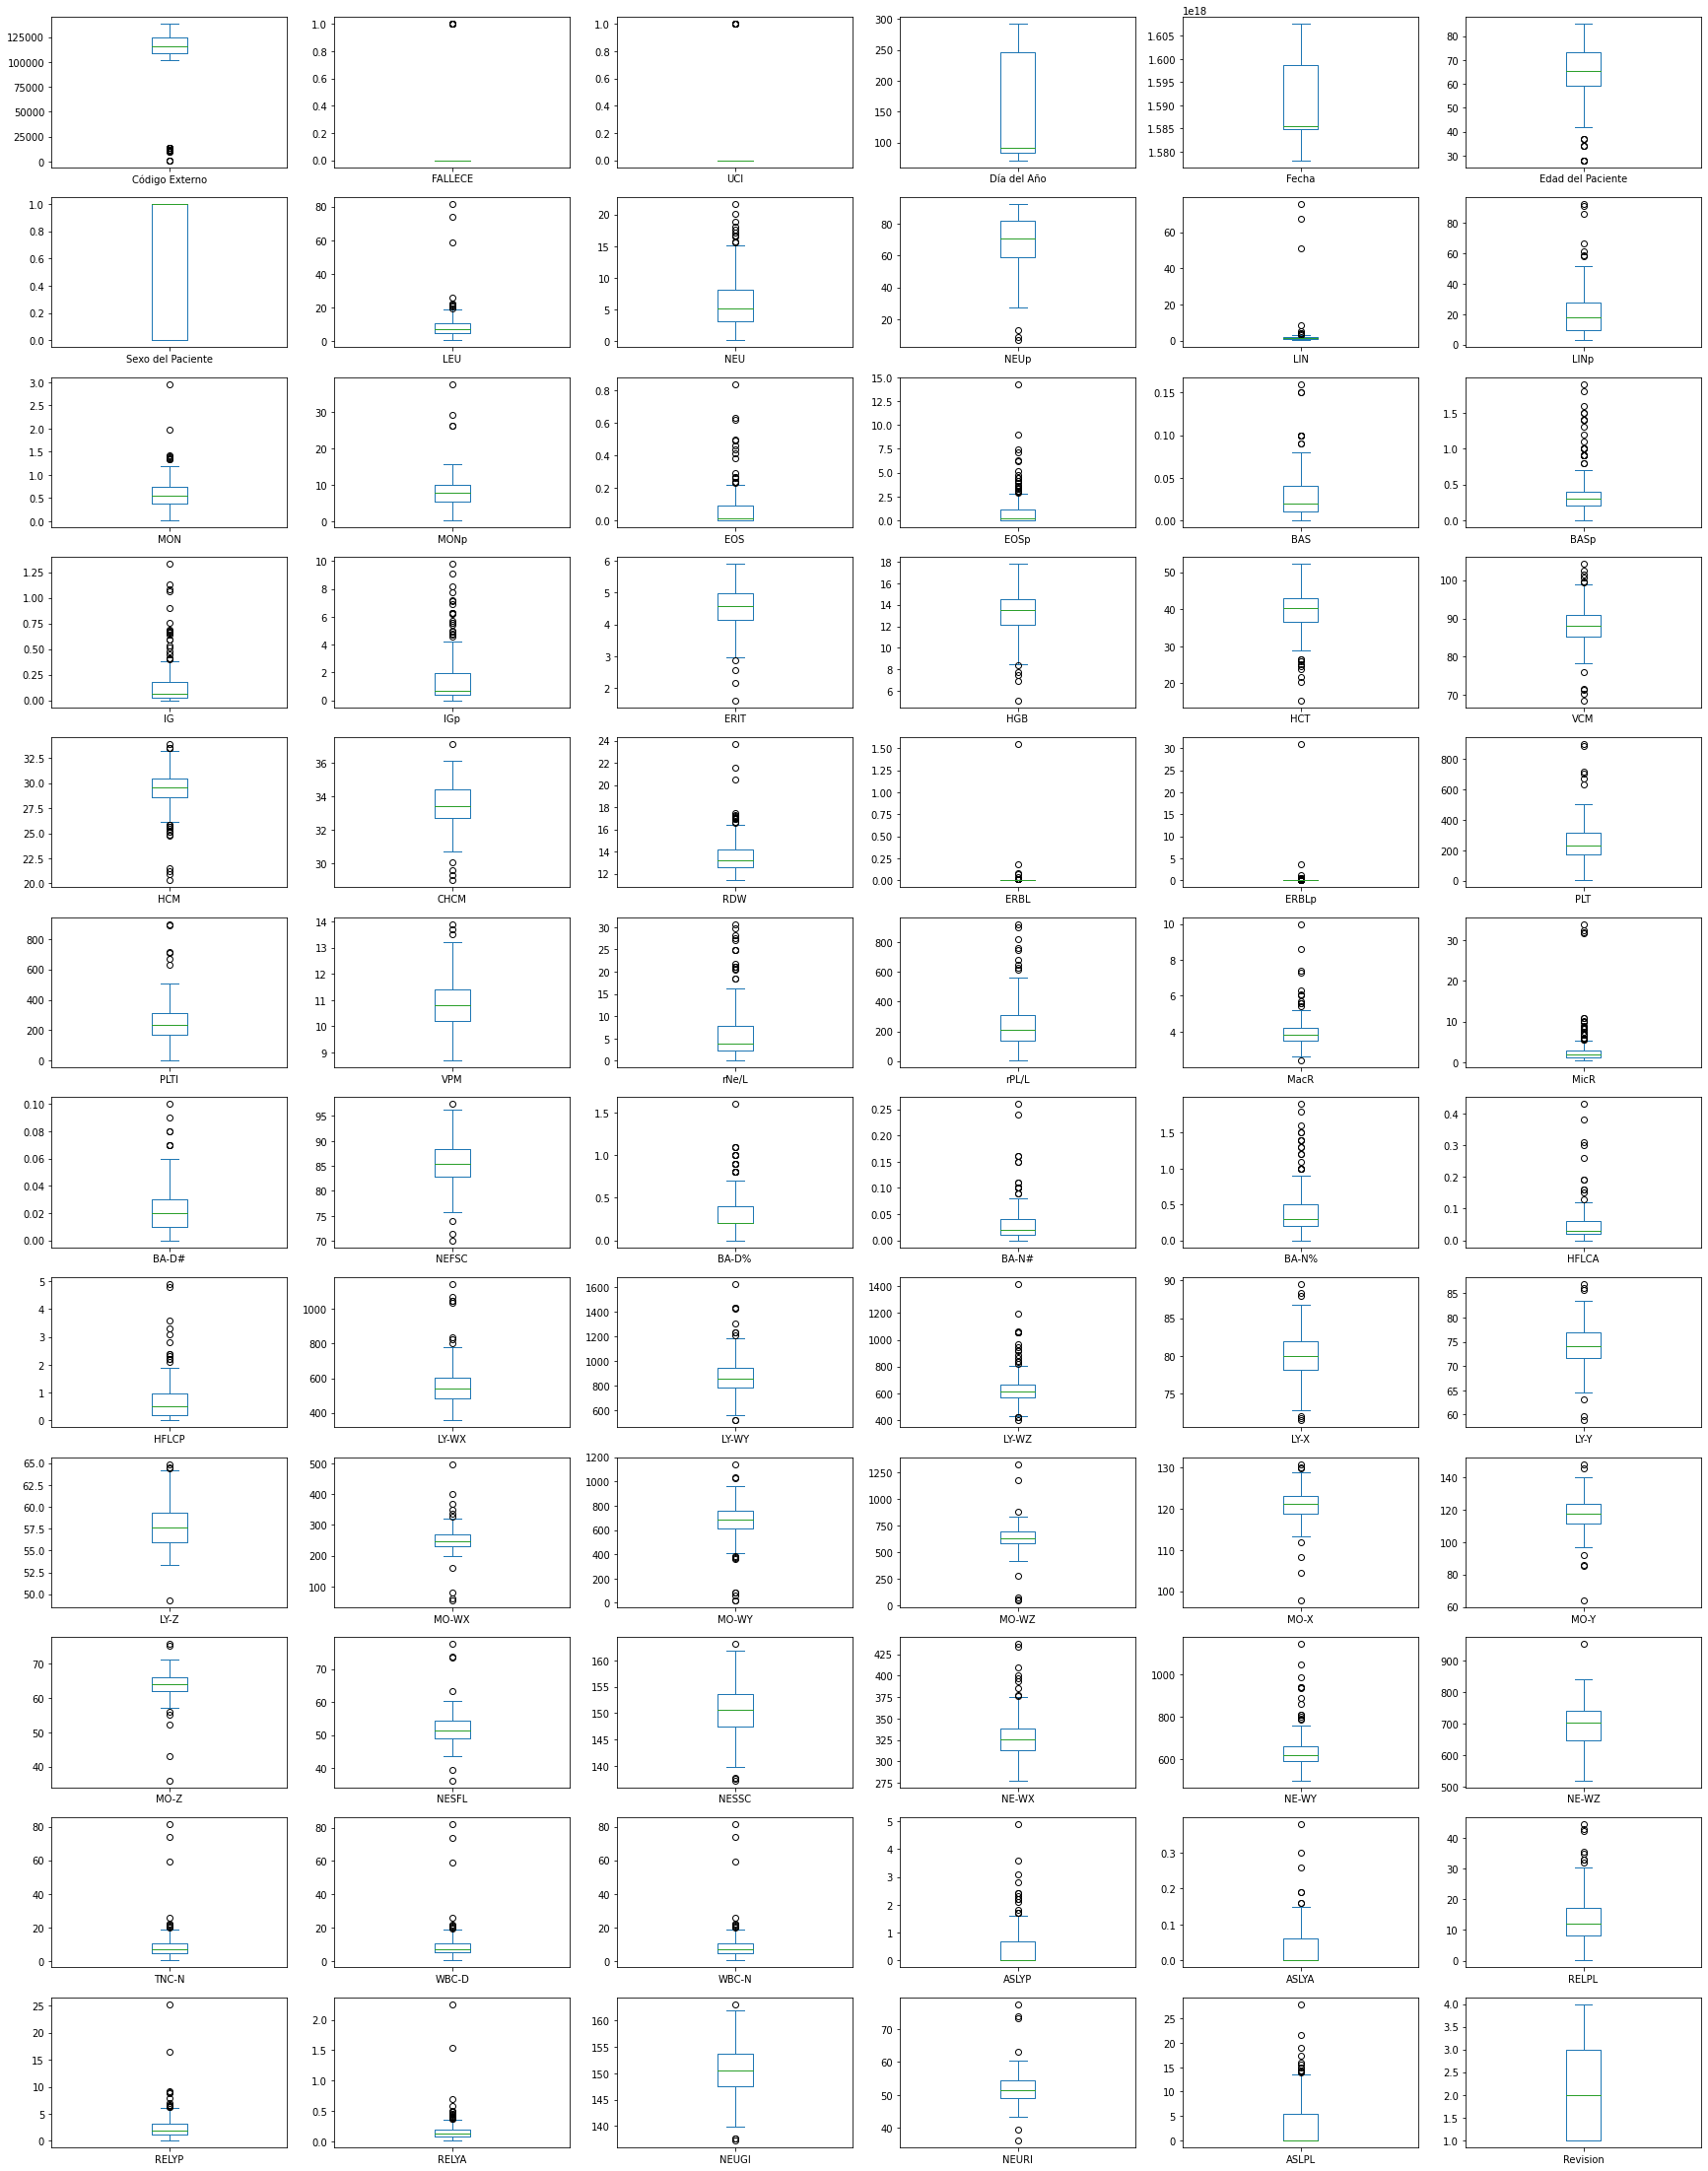

In [42]:
X_train.plot(kind='box',subplots=True, layout=(21,6), sharex=False, sharey=False, figsize=(30,70));

A continuación calculo el z-score. Cada puntuación z nos dice a cuántas desviaciones estándar se encuentra un valor individual de la media de los valores del conjunto que estoy estudiando.

El segundo paso, es calcular el z-score sin normalizar y comprobar si cada valor se encuentra dentro de 3 veces la desviación típica. En el caso de que se encuentren fuera de ese intervalo se le considera outlier y será reemplazado a NaN.

In [43]:
def outliers (datos,dtype): #Función z-score
    count=0
    lista=[]
    for i in dtype[datos]:
        if not (dtype[datos].mean()-3*dtype[datos].std())<=i<=(dtype[datos].mean()+3*dtype[datos].std()): # 3 veces la desviacion estandar
            if not np.isnan(i):
                count=count+1
                lista.append(i)
   
    return lista 

## Lectura de outliers e imputacion de los mismos en X_train

In [44]:
numeric_variables_train = X_train.select_dtypes(exclude=['object'])

for i in numeric_variables_train:
   X_train[[i]]=X_train[[i]].replace(outliers(i,X_train),np.nan) 

In [45]:
for index,value in enumerate (X_train.isnull().sum()):
  if value !=0:
    print(X_train.columns[index],value)

Código Externo 19
FALLECE 182
UCI 182
LEU 32
NEU 32
NEUp 32
LIN 32
LINp 33
MON 31
MONp 33
EOS 36
EOSp 35
BAS 32
BASp 37
IG 34
IGp 35
ERIT 31
HGB 31
HCT 32
VCM 34
HCM 33
CHCM 31
RDW 32
ERBL 30
ERBLp 30
PLT 35
PLTI 35
VPM 35
rNe/L 126
rPL/L 127
MacR 33
MicR 33
BA-D# 33
NEFSC 31
BA-D% 30
BA-N# 35
BA-N% 34
HFLCA 34
HFLCP 34
LY-WX 34
LY-WY 33
LY-WZ 35
LY-X 29
LY-Y 31
LY-Z 30
MO-WX 34
MO-WY 35
MO-WZ 34
MO-X 32
MO-Y 33
MO-Z 31
NESFL 33
NESSC 29
NE-WX 33
NE-WY 35
NE-WZ 30
TNC-N 32
WBC-D 32
WBC-N 32
ASLYP 38
ASLYA 37
RELPL 37
RELYP 36
RELYA 36
NEUGI 29
NEURI 33
ASLPL 37


## 2.1 ANALISIS DESCRIPTIVO (REGRESION LINEAL)

Vamos a realizar un análisis de tendendias para cada variable de forma poblacional. También usaremos este análisis de tendencias de forma individual para cada paciente, de forma que se pueda incorporar la información dinámica que genera dentro del modelo de predicción basado en machine learning.

Vamos a generar la función que obtiene el modelo de regresión lineal. El modelo que planteamos es un polinomio de segundo orden:

$y = a + bx + cx^2$ ;

donde la x corresponde al número de revisión.

In [46]:
from sklearn.linear_model import LinearRegression

def lin_reg_model(revi,x_val):
    """
    Función que ajusta un modelo de regresión lineal para el conjunto de datos que viene dado por rev y x_val. Vamos a usar
    sklearn, pero podríamos utilizar cualquier otro módulo de algebra lineal
    """
    
    #generamos la matrix X, que tiene que contener en una columna rev y en otra rev**2
    
    
    rev_2 = revi**2
    
    X = np.vstack((np.ones(revi.shape),revi,rev_2)).T #JA Como quiero un polinomio de segundo orden... meto
                      #unos que me sirven como "a", rev que me sirve como "b" y rev_2 que me sirve como "c"
    
    #ajustamos el modelo de regresion lineal
    
    #le digo false, para que me devuelva todo los coeficientes en coef_
    clf = LinearRegression(fit_intercept=False) #yo creo que lo que haría, para que fuesen todos comparables sería 
    # normalizar los datos pero no lo tengo claro, lo tendría que pensar
    
    clf.fit(X,x_val)
    
    #devolvemos los coeficientes
    return clf.coef_

In [47]:
#Calculo de medias según el dataframe y la variable

def mean_review(dataframe,variable):
    mean_array = []
    for i in dataframe['Revision'].unique(): ## JA, quiero que i coja los valores únicos. Es decir si aparece 1 que coja todos los 1 a la vez.
        df_mask=dataframe['Revision']==i
        filtered_df = dataframe[df_mask]

        mean_df = filtered_df[variable].mean()  
        #si tenemos valores que son NaN nos va a dar ese error
        mean_array.append(mean_df)
 
    return mean_array,filtered_df #Tengo que poner return en lugar de print, pues si pongo print cuando ejecuto la funcion me sale None junto a los valores. Y si me 
              #None, no puedo meter la función en lin_reg_model.

In [48]:
print(X_train.columns)

Index(['Código Externo', 'FALLECE', 'UCI', 'Día del Año', 'Fecha',
       'Edad del Paciente', 'Sexo del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'BA-D#',
       'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%', 'HFLCA', 'HFLCP', 'LY-WX', 'LY-WY',
       'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X',
       'MO-Y', 'MO-Z', 'NESFL', 'NESSC', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'Revision'],
      dtype='object')


[4.582280701754386, 5.392558139534885, 6.097450980392157, 6.520769230769231]
[7.3536363636363635, 6.72, 8.602, 7.4941666666666675]
[ 3.53447617  1.13573483 -0.0967398 ]
[ 6.37380682  0.8231053  -0.11854924]


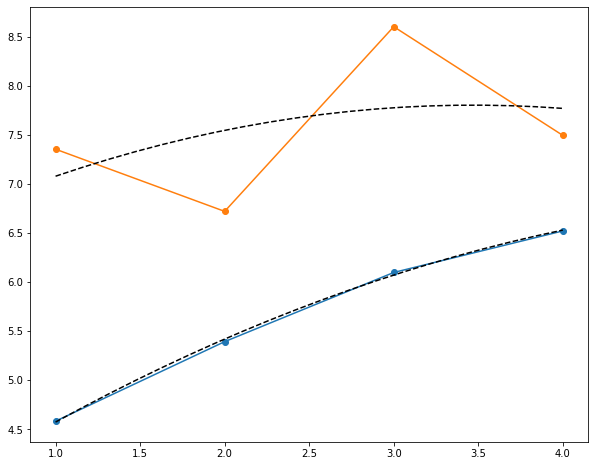

In [49]:
revi= np.array([1,2,3,4])

#ojo el label lo tenemos que coger de y_train
print(mean_review(X_train[y_train==0],'NEU')[0]) #Al final pone 0 porque de las dos cosas que imprime (mean_array) y (filtered) se quiere quedar
                                                #con la primera, es decir con el "mean_array"
print(mean_review(X_train[y_train==1],'NEU')[0])

sanos_means,_ = mean_review(X_train[y_train==0],'NEU') 

no_sanos_means,_ = mean_review(X_train[y_train==1],'NEU')

coef_sanos = lin_reg_model(revi,sanos_means)
coef_no_sanos = lin_reg_model(revi,no_sanos_means)

print(coef_sanos)
print(coef_no_sanos)

plt.figure(figsize = (10,8))
xx = np.linspace(1,4,20)

XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T

plt.plot(revi,sanos_means,'o-')
plt.plot(revi,no_sanos_means,'o-')
plt.plot(xx,XX.dot(coef_sanos),'k--',label = 'real values')
plt.plot(xx,XX.dot(coef_no_sanos),'k--',label = 'regression model')

In [50]:
#Creo una lista con los nombres de las columnas a las que me interesa sacar los coeficientes
columns_names = X_train.columns.values
columns_names_list = list(columns_names)
feat_name = columns_names_list[7:-1] #cojo todas las variables hasta la penultima

for i in feat_name:
    sanos_means,_ = mean_review(X_train[y_train==0],i)
    no_sanos_means,_ = mean_review(X_train[y_train==1],i)  
    print("Coeficientes de", i ,": \n SANOS:",lin_reg_model(revi,sanos_means),"\n NO SANOS:",lin_reg_model(revi,no_sanos_means))

##ME DA ERROR: quizá sea porque tengo que hacer esto después de sustituir los NaN ?¿?¿?¿?¿?

Coeficientes de LEU : 
 SANOS: [ 7.23115049 -0.49959167  0.29832918] 
 NO SANOS: [ 7.91488492  0.82246905 -0.0585754 ]
Coeficientes de NEU : 
 SANOS: [ 3.53447617  1.13573483 -0.0967398 ] 
 NO SANOS: [ 6.37380682  0.8231053  -0.11854924]
Coeficientes de NEUp : 
 SANOS: [62.53250808  4.48949016 -0.780825  ] 
 NO SANOS: [80.87164683 -5.56515476  1.33906746]
Coeficientes de LIN : 
 SANOS: [ 1.7552894  -0.45144758  0.1171305 ] 
 NO SANOS: [ 0.19128175  0.64676429 -0.13425794]
Coeficientes de LINp : 
 SANOS: [25.08406443 -3.03511208  0.4907046 ] 
 NO SANOS: [15.58080128 -3.17467308  0.54804487]
Coeficientes de MON : 
 SANOS: [ 0.63396356 -0.10480749  0.03034305] 
 NO SANOS: [ 0.27477273  0.20046084 -0.03313636]
Coeficientes de MONp : 
 SANOS: [ 9.59610741 -1.40435703  0.25068016] 
 NO SANOS: [ 4.68125     1.35441667 -0.32458333]
Coeficientes de EOS : 
 SANOS: [ 0.05849574  0.00121839 -0.00112735] 
 NO SANOS: [ 0.1059478  -0.05511484  0.00831593]
Coeficientes de EOSp : 
 SANOS: [ 1.43695546 

In [51]:
#Vamos a comprobar el ajuste

xx = np.linspace(1,4,255) #tengo que poner el mismo número de muestras que el dataframe de sanos_df para que la gráfica nueva que pinto
                                #pueda superponerse.


XX = np.vstack((np.ones(xx.shape),xx,xx**2)).T



#Lo que hago es meter todo en una única linea:
#XX_no_sanos.dot(lin_reg_model(revi,mean(no_sanos_df,'LEU')))

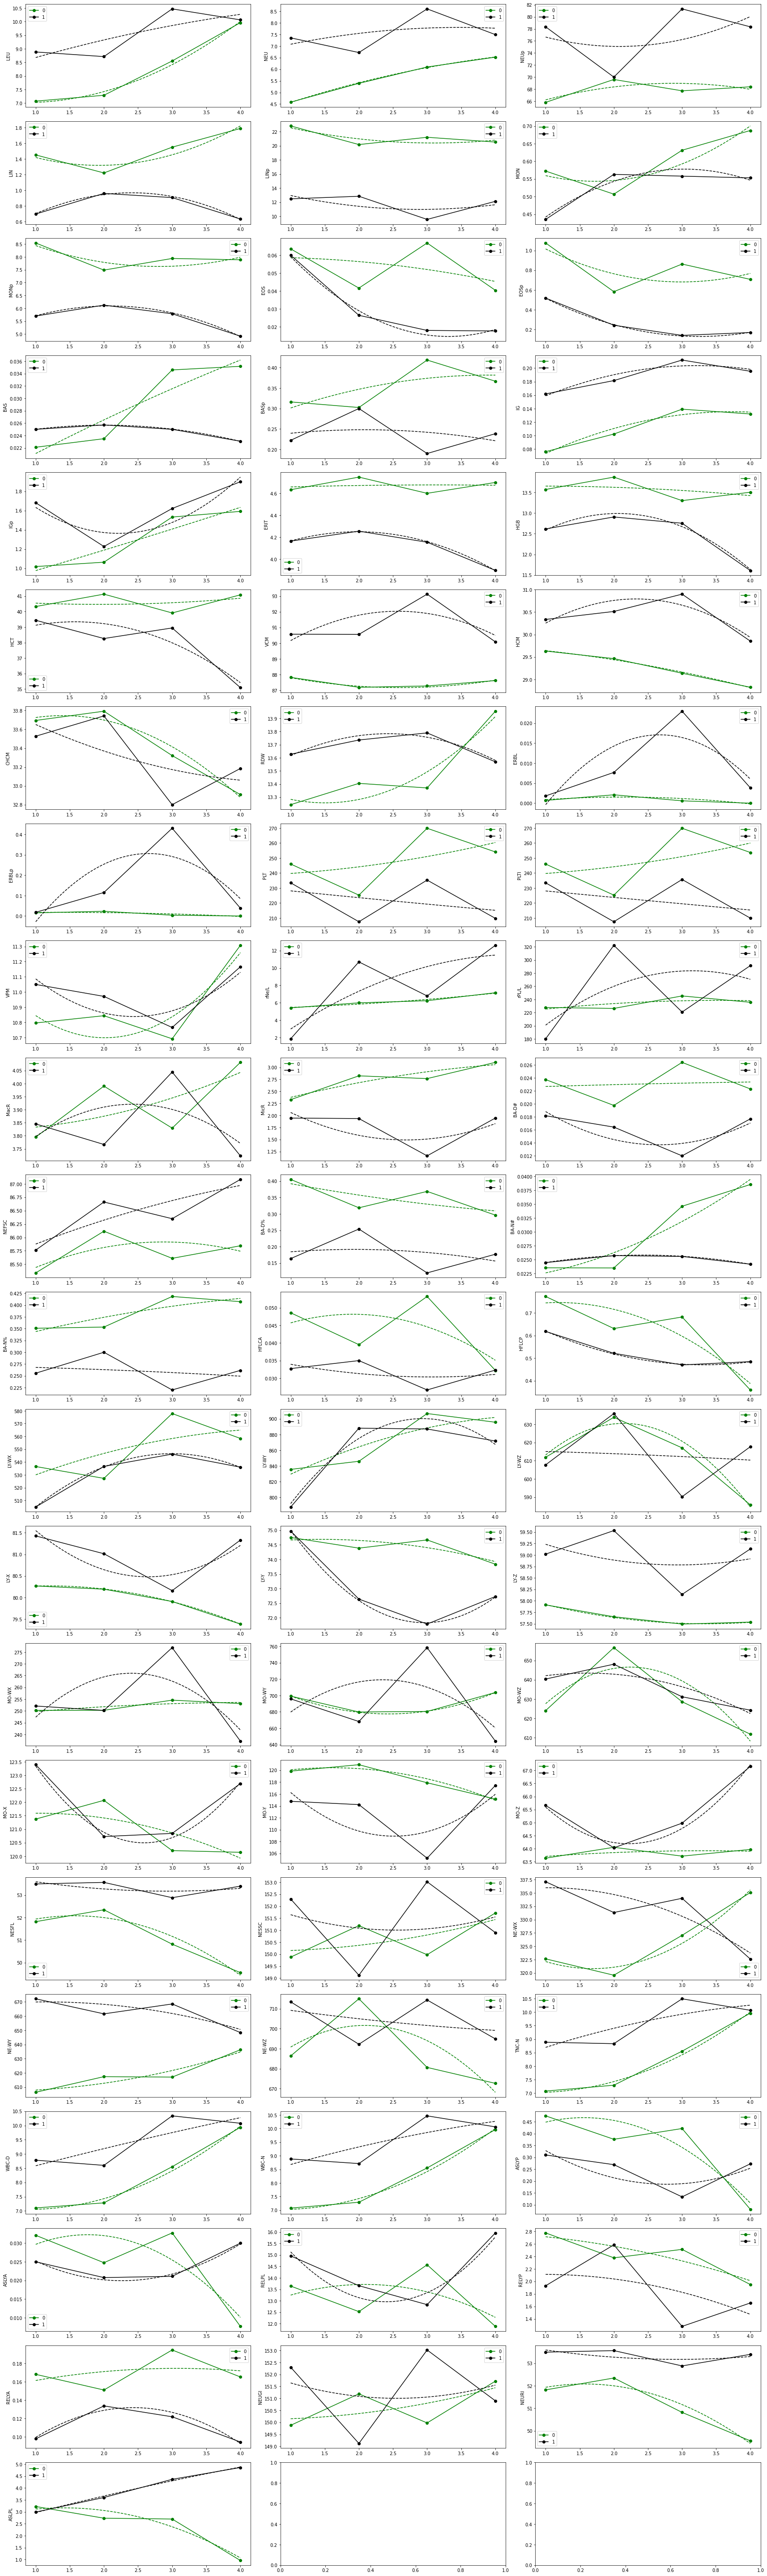

In [52]:
list_axes = []
for j in range(22):
    for i in range(3):
        list_axes.append([j,i])
        
#creamos lista de índices

fig, axes = plt.subplots(22, 3, figsize=(24, 80)) #figsize = width x height

for ii in range(len(list_axes)-2):
    #print(list_axes[ii])
    #print(feat_name[ii])
    
    sanos_means,_ = mean_review(X_train[y_train==0],feat_name[ii])
    no_sanos_means,_ = mean_review(X_train[y_train==1],feat_name[ii])
    axes[list_axes[ii][0],list_axes[ii][1]].plot([1,2,3,4],sanos_means,'go-',label='0')
    #sns.lineplot(ax=axes[list_axes[ii][0],list_axes[ii][1]],data=X_train[y_train==1], x="Revision",y=feat_name[ii], hue=y_train, palette=['red'],linewidth=2.5, ci=None, marker="o", markersize= 12)
    axes[list_axes[ii][0],list_axes[ii][1]].plot(xx,XX.dot(lin_reg_model(revi,sanos_means)),'g--')
    axes[list_axes[ii][0],list_axes[ii][1]].plot([1,2,3,4],no_sanos_means,'ko-',label='1')
    #sns.lineplot(ax=axes[list_axes[ii][0],list_axes[ii][1]],data=X_train[y_train==0], x="Revision", y=feat_name[ii], hue=y_train,palette=['black'], linewidth=2.5, ci=None, marker="o", markersize= 12)
    axes[list_axes[ii][0],list_axes[ii][1]].plot(xx,XX.dot(lin_reg_model(revi,no_sanos_means)),'k--')
    axes[list_axes[ii][0],list_axes[ii][1]].legend()
    axes[list_axes[ii][0],list_axes[ii][1]].set_ylabel(feat_name[ii])
    
plt.tight_layout()
    

A continuación haré uso de KNNImputer. KNNImputer es una clase de scikit-learn que se utiliza para completar o predecir los valores faltantes en un conjunto de datos. Es un método que funciona con el enfoque básico del algoritmo KNN y que se considera que proporciona una mejor rendiemiento que otros enfoques, como puedes ser la imputación de los outliers por la media o la mediana.

El siguiente código tiene como fin, ayudar en la elección del número K óptimo con el que realizar la imputación de los outliers convertidos en NaN. La investigación sugiere que es imperativo probar el modelo usando validación cruzada después de realizar la imputación con diferentes valores de k. Aunque la imputación de valores perdidos es un campo de estudio en constante evolución, kNN actúa como una estrategia simple y efectiva.

Al final de la ejecución, se crea un diagrama de caja y bigotes para cada conjunto de resultados, lo que permite comparar la distribución de los valores finales.

>1 0.852 (0.036)
>3 0.875 (0.033)
>5 0.876 (0.039)
>7 0.879 (0.035)
>9 0.882 (0.041)
>15 0.881 (0.037)
>18 0.879 (0.038)
>21 0.879 (0.036)
>25 0.881 (0.040)
>30 0.881 (0.040)
>36 0.882 (0.039)
>40 0.881 (0.040)


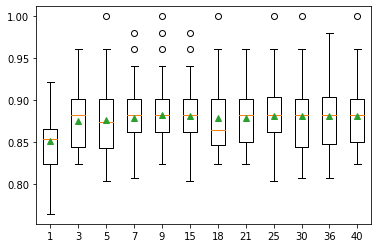

In [53]:
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in [1,3,5,7,9,15,18,21,25,30,36,40]]
for s in strategies:
    # create the modeling pipeline
    
    #me parece ok usar RF
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])  ###NO SE QUE ALGORITMO UTILIZAR
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)  ###NO SE QUE NUMEROS PONER EN LOS PARAMETROS
    #Pongo X_train e y_train, ya que son los conjuntos sobre los que voy a trabajar
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1) ###NO SE QUE X E Y PONER
    # store results
    results.append(scores)
    print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

En este caso, podemos ver que los valores de k no siguen una uniformidad a la hora de dar un rendimiento óptimo del algoritmo en cuestión. Por lo tanto, se puede observar que para un k = --- el modelo presenta el mejor rendimiento con una precisión de alrededor de --- por ciento.


**Óscar**

Si te fijas sólo en las medias (los triangulitos, se ve que enseguida saturan y se ponen a un buen nivel, así que lo que yo haría sería quderme con un ńumero relativamente pqueño, por ejemplo 5)

Por esa razón, utilizaremos dicho valor de K en KNNImputer. Además, tendremos en cuenta otros 2 parámetros. 



*   Por un lado, se tiene en cuenta la medida de distancia, la cual se puede ponderar proporcionalmente a la distancia entre instancias (filas), aunque esto se establece en una ponderación uniforme por defecto, controlada a través del argumento "weights". En este caso, se opta por darle un valor unirforme, por lo que todas las muestras tienen la misma importancia a la hora de "influenciar" a la muestra NaN.

*   Por otro lado, se encuentra el parámetro "metric", el cual hace referencia a la medida de distancia que se utilizará para calcular la distancia entre los miembros del conjunto de datos de entrenamiento. Esta vez se opta por la distancia euclidea, ya que es la distancia utilizada en algunos de los principales métodos para ajustar estimaciones estadísticas de los datos minimizando errores, como el método de mínimos cuadrados.



In [54]:
from sklearn.impute import KNNImputer
from numpy import isnan

# print total missing
print('Total missing values before imputation: %d' % X_train.isnull().sum().sum())

# define imputer
imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean') #Se calcula la distancia euclidea del punto NaN a los n vecinos 
                                      # mas cercanos. Además se le da un peso uniforme a todos los vecinos, es decir todos los vecinos tienen
                                      # la misma importancia.

# fit on the dataset
imputer.fit(X_train)

# transform the dataset
X_train = imputer.transform(X_train)

# print total missing
print('Total missing values after imputation: %d' % sum(isnan(X_train).flatten()))

Total missing values before imputation: 2686
Total missing values after imputation: 0


In [55]:
X_train = pd.DataFrame(X_train)

#Compruebo que no queda ningún NaN en la base de datos. De esa manera ya puedo trabajar con ella.
check_for_nan = X_train.isnull().values.any()
print (check_for_nan)

False


## Lectura de outliers e imputacion de los mismos en X_test





In [56]:
numeric_variables_test = X_test.select_dtypes(exclude=['object'])

for i in numeric_variables_test:
   X_test[[i]]=X_test[[i]].replace(outliers(i,X_test),np.nan) 

In [57]:
for index,value in enumerate (X_test.isnull().sum()):
  if value !=0:
    print(X_test.columns[index],value)

FALLECE 44
UCI 44
Edad del Paciente 1
LEU 9
NEU 8
NEUp 7
LIN 9
LINp 7
MON 8
MONp 7
EOS 7
EOSp 8
BAS 8
BASp 9
IG 8
IGp 8
ERIT 8
HGB 8
HCT 8
VCM 9
HCM 8
CHCM 7
RDW 8
ERBL 7
ERBLp 8
PLT 10
PLTI 10
VPM 8
rNe/L 36
rPL/L 36
MacR 8
MicR 8
BA-D# 7
NEFSC 9
BA-D% 8
BA-N# 8
BA-N% 9
HFLCA 9
HFLCP 8
LY-WX 8
LY-WY 7
LY-WZ 7
LY-X 8
LY-Y 7
LY-Z 7
MO-WX 8
MO-WY 8
MO-WZ 7
MO-X 7
MO-Y 8
MO-Z 7
NESFL 9
NESSC 8
NE-WX 8
NE-WY 9
NE-WZ 7
TNC-N 9
WBC-D 9
WBC-N 9
ASLYP 9
ASLYA 9
RELPL 9
RELYP 9
RELYA 9
NEUGI 8
NEURI 9
ASLPL 8


In [58]:
# print total missing
print('Total missing values before imputation: %d' % X_test.isnull().sum().sum())

#OJO: yo diría que esto es una mala práctica, no es malísima, pero no estás siendo justo. Lo ideal es, ahora
#que has entrenado el model en training bien (el KNNImputer), utilizar ese entrenamiento con los nuevos datos, no 
#volver a ajustar los datos. 

# define imputer
#imputer = KNNImputer(n_neighbors=21, weights='uniform', metric='nan_euclidean')

# fit on the dataset
#imputer.fit(X_test)

# transform the dataset
X_test = imputer.transform(X_test)

# print total missing
print('Total missing values after imputation: %d' % sum(isnan(X_test).flatten()))

Total missing values before imputation: 664
Total missing values after imputation: 0


In [59]:
X_test = pd.DataFrame(X_test)

#Compruebo que no queda ningún NaN en la base de datos. De esa manera ya puedo trabajar con ella.
check_for_nan = X_test.isnull().values.any()
print (check_for_nan)

False


# 3. Modelos de machine learning

## XGBoost

In [60]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score


In [61]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred)
sensibilidad_xgb = recall_score(y_test, y_pred)
#precision_xgb = precision_score(y_test, y_pred)
specificity_xgb = confusion_matrix(y_test, y_pred)[0][0]/(confusion_matrix(y_test, y_pred)[0][0]+confusion_matrix(y_test, y_pred)[0][1])
auc_xgb = roc_auc_score(y_test, y_pred)

Tabla = pd.DataFrame({ "Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                      "XGBoost" : [acc_xgb, sensibilidad_xgb, specificity_xgb, auc_xgb]})

Tabla

,Prestaciones en test,XGBoost
0,Accuracy,0.828125
1,Sensibility,0.083333
2,Specificity,1.000000
3,AUC ROC,0.541667
